In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calculate_risk_contribution(weights, cov_matrix):
    """
    Computes the contribution of each asset to the portfolio's total volatility.
    Formula: RC_i = w_i * (Sigma * w)_i / sqrt(w.T * Sigma * w)
    """
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    port_volatility = np.sqrt(port_variance)
    
    mcr = np.dot(cov_matrix, weights) / port_volatility
    
    rc = weights * mcr
    
    return rc / rc.sum()

def risk_parity_objective(weights, cov_matrix):
    """
    The Loss Function. 
    We want all Risk Contributions (RC) to be equal.
    So we minimize the variance of the RC vector.
    """
    rc = calculate_risk_contribution(weights, cov_matrix)
    target_rc = 1 / len(weights) 
    
    loss = np.sum(np.square(rc - target_rc))
    return loss

In [3]:
def get_risk_parity_weights(cov_matrix):
    """
    Uses Scipy Optimize to find weights that equalize risk contribution.
    """
    n_assets = len(cov_matrix)
    
    initial_weights = np.ones(n_assets) / n_assets
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})
    
    bounds = tuple((0.0, 1.0) for _ in range(n_assets))
    
    result = minimize(
        fun=risk_parity_objective,
        x0=initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        tol=1e-9 # High precision
    )
    
    if not result.success:
        raise ValueError("Optimization failed to converge!")
        
    return pd.Series(result.x, index=cov_matrix.columns, name="RiskParity")

In [4]:
def fetch_data(tickers,start_date,end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    print(data.head())
    return data

In [7]:
def calculate_returns(prices, method='log'):
    if method == 'simple':
        returns = prices.pct_change().dropna()
    elif method == 'log':
        returns = np.log(prices / prices.shift(1)).dropna()
    
    return returns

In [9]:
def get_ledoit_wolf_covariance(returns):
    lw = LedoitWolf()
    lw.fit(returns)
    
    cov_lw = lw.covariance_ * 252
    
    cov_df = pd.DataFrame(
        cov_lw, 
        index=returns.columns, 
        columns=returns.columns
    )
    return cov_df

In [23]:
tickers = ['NVDA', 'TLT', 'GLD']
data = fetch_data(tickers, '2019-01-01', '2023-12-31')
returns = calculate_returns(data)
cov = get_ledoit_wolf_covariance(returns)

# 1. Naive Equal Weight (Benchmark)
w_eq = pd.Series([1/3]*3, index=tickers, name="Equal Weight")

# 2. Naive Inverse Volatility
inv_vol = 1 / np.sqrt(np.diag(cov))
w_ivp = pd.Series(inv_vol / inv_vol.sum(), index=tickers, name="IVP")

# 3. Risk Parity
w_rp = get_risk_parity_weights(cov)

rc_rp = calculate_risk_contribution(w_rp.values, cov.values)

print("--- Allocation Weights ---")
results = pd.DataFrame({'Equal Weight': w_eq, 'IVP': w_ivp, 'Risk Parity': w_rp})
print(results.round(3))

print("\n--- Risk Contribution (Risk Parity Portfolio) ---")
print(pd.Series(rc_rp, index=tickers).round(4))

/var/folders/v6/hggmpf4134v8nppmrh142shw0000gn/T/ipykernel_45185/2377045159.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed

Ticker             GLD      NVDA         TLT
Date                                        
2019-01-02  121.330002  3.377354  101.310379
2019-01-03  122.430000  3.173304  102.463226
2019-01-04  121.440002  3.376611  101.277199
2019-01-07  121.860001  3.555371  100.978645
2019-01-08  121.529999  3.466858  100.713203
--- Allocation Weights ---
      Equal Weight    IVP  Risk Parity
GLD          0.333  0.397        0.439
NVDA         0.333  0.465        0.154
TLT          0.333  0.138        0.407

--- Risk Contribution (Risk Parity Portfolio) ---
NVDA    0.3333
TLT     0.3333
GLD     0.3333
dtype: float64


/var/folders/v6/hggmpf4134v8nppmrh142shw0000gn/T/ipykernel_45185/2377045159.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed

Ticker             GLD      NVDA        SHY
Date                                       
2019-01-02  121.330002  3.377354  72.166924
2019-01-03  122.430000  3.173304  72.313629
2019-01-04  121.440002  3.376611  72.158302
2019-01-07  121.860001  3.555371  72.106506
2019-01-08  121.529999  3.466858  72.063377


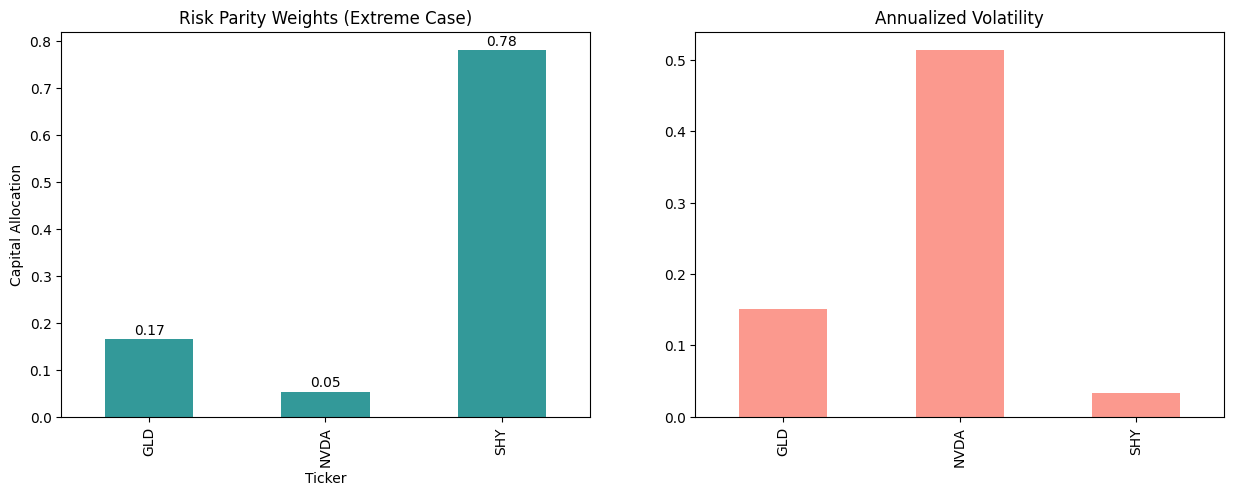

In [26]:
# The Extreme Case
extreme_tickers = ['GLD', 'NVDA', 'SHY']
data_ext = fetch_data(extreme_tickers, '2019-01-01', '2023-12-31')
returns_ext = calculate_returns(data_ext)
cov_ext = get_ledoit_wolf_covariance(returns_ext)

w_rp_ext = get_risk_parity_weights(cov_ext)

w_eq_ext = pd.Series([1/3]*3, index=extreme_tickers, name="Equal Weight")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

w_rp_ext.plot(kind='bar', ax=axes[0], color='teal', alpha=0.8)
axes[0].set_title("Risk Parity Weights (Extreme Case)")
axes[0].set_ylabel("Capital Allocation")
for i, v in enumerate(w_rp_ext):
    axes[0].text(i, v + 0.01, f"{v:.2f}", ha='center')

vol_ext = np.sqrt(np.diag(cov_ext))
pd.Series(vol_ext, index=extreme_tickers).plot(kind='bar', ax=axes[1], color='salmon', alpha=0.8)
axes[1].set_title("Annualized Volatility")

plt.show()

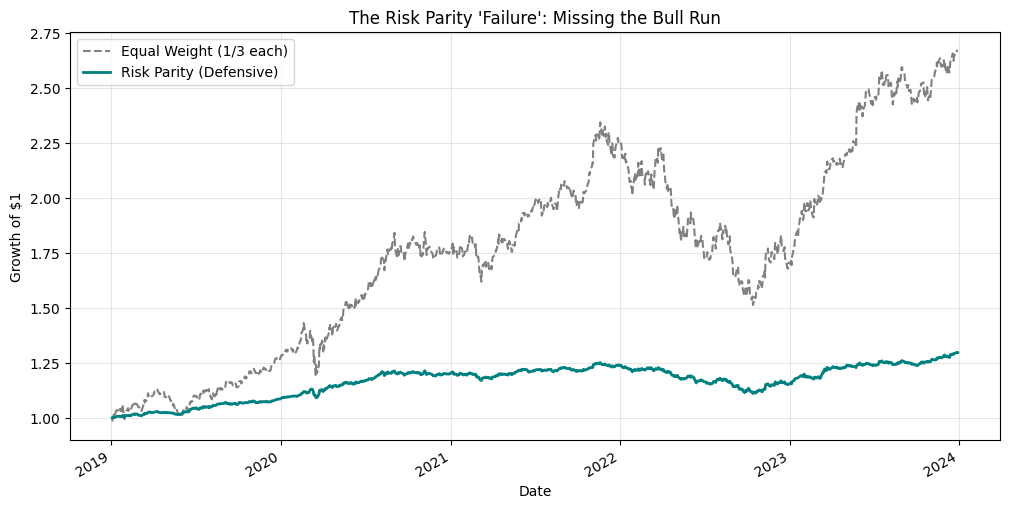

Total Return (Equal Weight): 166.73%
Total Return (Risk Parity):  29.63%


In [28]:
# Performance Lag)

port_ret_rp = (returns_ext * w_rp_ext).sum(axis=1)
port_ret_eq = (returns_ext * w_eq_ext).sum(axis=1)

cum_ret_rp = (1 + port_ret_rp).cumprod()
cum_ret_eq = (1 + port_ret_eq).cumprod()

plt.figure(figsize=(12, 6))
cum_ret_eq.plot(label='Equal Weight (1/3 each)', color='gray', linestyle='--')
cum_ret_rp.plot(label='Risk Parity (Defensive)', color='teal', linewidth=2)

plt.title("The Risk Parity 'Failure': Missing the Bull Run")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

total_ret_rp = cum_ret_rp.iloc[-1] - 1
total_ret_eq = cum_ret_eq.iloc[-1] - 1

print(f"Total Return (Equal Weight): {total_ret_eq:.2%}")
print(f"Total Return (Risk Parity):  {total_ret_rp:.2%}")